# Example use case for using connectors module
By Gregory Glickert

### First we will start with an example network 

In [1]:
from bmtk.builder import NetworkBuilder
from bmtk.builder.auxi.node_params import positions_cuboid,positions_list,xiter_random
import numpy as np
import os

# this will be used later
if os.path.isfile("conn.csv"):
    os.remove("conn.csv")

# cell count
num_of_PN = 250
num_of_FSI = 50
# generate rand postions
postions = positions_cuboid(num_of_PN+num_of_FSI,min_dist=10)

# select locations 
inds = np.random.choice(np.arange(0, np.size(postions, 0)), num_of_PN, replace=False)
pos = postions[inds, :]
net = NetworkBuilder('bio_net')
net.add_nodes(N=num_of_PN, 
              pop_name='PN',
              positions=positions_list(pos),
              model_type='biophysical',
              morphology=None)
# Get rid of coordinates already used
postions = np.delete(postions, inds, 0)

inds = np.random.choice(np.arange(0, np.size(postions, 0)), num_of_FSI, replace=False)
pos = postions[inds, :]
net.add_nodes(N=num_of_FSI, 
              pop_name='FSI',
              positions=positions_list(pos),
              model_type='biophysical',
              morphology=None)

background = NetworkBuilder('background')
background.add_nodes(N=num_of_FSI+num_of_PN,
                   pop_name='background_nodes',
                   potential='exc',
                   model_type='virtual')


Now that we have our nodes we can start building some edges with the bmtool.connectors module. There are two main types of network models either homogenous or distance depended. A homogenous network will form connections using a constant probability, while a distance depended model will vary its probability based off how far away the cell pairs are from each other.

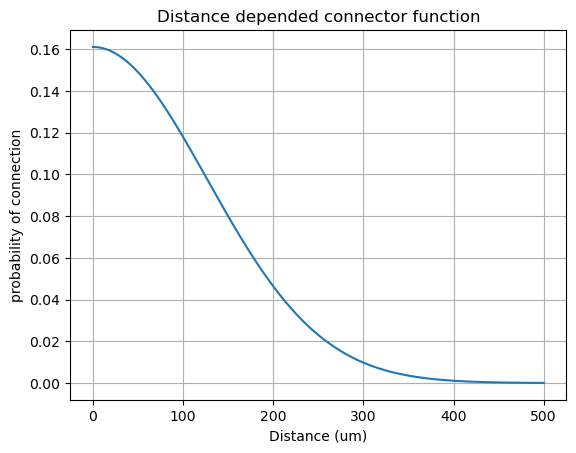

In [2]:
from bmtool.connectors import GaussianDropoff
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

drop_off = GaussianDropoff(stdev=126.77, min_dist=0, max_dist=300,
                           ptotal=0.1538, ptotal_dist_range=(0, 50.),
                           dist_type='spherical')

distances = np.linspace(0, 500, 1000)
probabilities_for_dropoff = drop_off.probability(distances)
plt.plot(distances, probabilities_for_dropoff,label=f'Pmax={drop_off.pmax:.2f} Sigma={drop_off.stdev}')
plt.title("Distance depended connector function")
plt.xlabel("Distance (um)")
plt.ylabel("probability of connection")
plt.grid(True)
plt.show()

## UnidirectionalConnector
The UnidirectionalConnector will make one way or forward connection from the source population to the target population. p is the probability of a connection forming. P can be constant or a deterministic function whose value must be within the range 0 to 1. When p is a constant this will form a homogenous network and the deterministic function can be used to make a distance depended network. There is an optional argument p_arg which are input argument(s) for the p function when using a deterministic function. The example below will use the built in GaussianDropoff.



In [3]:
from bmtool.connectors import UnidirectionConnector, spherical_dist

# distance depeneded example 
connector = UnidirectionConnector(p=drop_off, # function from above cell
                                  p_arg=spherical_dist, # spherical distance meaning check x,y,z for distance calculation
                                  verbose=False,
                                  save_report=True)
connector.setup_nodes(source=net.nodes(pop_name = ['PN']), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())

# constant p example
connector = UnidirectionConnector(p=0.10,verbose=False,save_report=True)
connector.setup_nodes(source=net.nodes(pop_name = ['PN']), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())

## ReciprocalConnector
The ReciprocalConnector takes in similar arguments but this time we have p0,p1 and pr. p0 is the probability of a forward connections, p1 is the probability of a backwards connection or a connection from target to source. pr is the probability of reciprocal connection. This connections can get very complex and the Pydocs [here](https://github.com/cyneuro/bmtool/blob/master/bmtool/connectors.py#L408) has more details on how to use the function.

An important thing to note here is how the ReciprocalConnector is called twice. Once for the forward connection and once for the backwards connection. The connector will factor in the reciprocal connections while doing the forward and backwards connections.

In [4]:
from bmtool.connectors import ReciprocalConnector

# sets up a homogenous network forward prob of 22%, backwards prob of 36% with a reciprocal probs of 17% for both connections 
connector = ReciprocalConnector(p0=0.22,p1=0.36,pr=0.17,verbose=False,save_report=True)
connector.setup_nodes(source=net.nodes(pop_name = ['PN']), target=net.nodes(pop_name = ['FSI']))
net.add_edges(**connector.edge_params())
# have to run setup_nodes for both directions since we have forwards and backwards probs.
connector.setup_nodes(source=net.nodes(pop_name = ['FSI']), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())

## GapJunction
The GapJunction connector is similar to the UnidirectionConnector, but will only form electrical synapses between pairs.

In [5]:
from bmtool.connectors import GapJunction

connector = GapJunction(p=0.10,verbose=False,save_report=True)
connector.setup_nodes(source=net.nodes(pop_name = ['FSI']), target=net.nodes(pop_name = ['FSI']))
net.add_edges(is_gap_junction=True,**connector.edge_params())

## CorrelatedGapJunction
NEED TO ADD THIS

## OneToOneSequentialConnector
The OneToOneSequentialConnector is a way to connection two populations one to one. Meaning that only one node from pop A will form a synapses onto one node from pop B. This is normally how background synapses can be modeled. In the example below a one background node is connected to one PN cell in our network. 

In [6]:
from bmtool.connectors import OneToOneSequentialConnector

connector = OneToOneSequentialConnector(verbose=False)
connector.setup_nodes(source=background.nodes(), target=net.nodes(pop_name = ['PN']))
net.add_edges(**connector.edge_params())
connector.setup_nodes(target=net.nodes(pop_name = 'FSI'))
net.add_edges(**connector.edge_params())

In [7]:
net.save('network/')
background.save('network/')


from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='./',      
                network_dir='network/',
                tstop=3000.0, dt=0.1,
                spikes_inputs=[('background', 
                                'background.h5')], 
                include_examples=False,    
                compile_mechanisms=False,   
                config_file='config.json',
                overwrite_config=True
                )